In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetDualHead(nn.Module):
    def __init__(self):
        super(UNetDualHead, self).__init__()

        def conv_block(input_channels, output_channels):
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True),
                nn.Conv2d(output_channels, output_channels, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True),
            )

        # Shared encoder
        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Shared bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder (shared for both heads)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.dec1 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.dec2 = conv_block(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.dec3 = conv_block(128, 64)

        # Dual output heads
        self.out_edge = nn.Conv2d(64, 1, kernel_size = 1)
        self.out_corner = nn.Conv2d(64, 1, kernel_size = 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))

        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e3], dim = 1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e2], dim = 1))
        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, e1], dim = 1))

        out_edge = torch.sigmoid(self.out_edge(d3))
        out_corner = torch.sigmoid(self.out_corner(d3))

        return torch.cat([out_edge, out_corner], dim = 1)  # shape: [B, 2, H, W]

In [2]:
from torch.utils.data import DataLoader, random_split
# sys.path.append(os.path.abspath('..'))  # Adding parent directory to system path
from dataset import EdgeCornerDataset

dataset = EdgeCornerDataset(root_dir = "../data/filtered_crops/")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 4)

In [3]:
from torch import no_grad
import matplotlib.pyplot as plt

model = UNetDualHead()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get a batch from the DataLoader
batch = next(iter(train_loader))
images, labels = batch

images = images.to(device)

model.eval()
with no_grad():
    outputs = model(images)

print("Input shape:", images.shape)       # [B, 3, 512, 512]
print("Output shape:", outputs.shape)   # [B, 2, 512, 512]

Input shape: torch.Size([4, 3, 512, 512])
Output shape: torch.Size([4, 2, 512, 512])


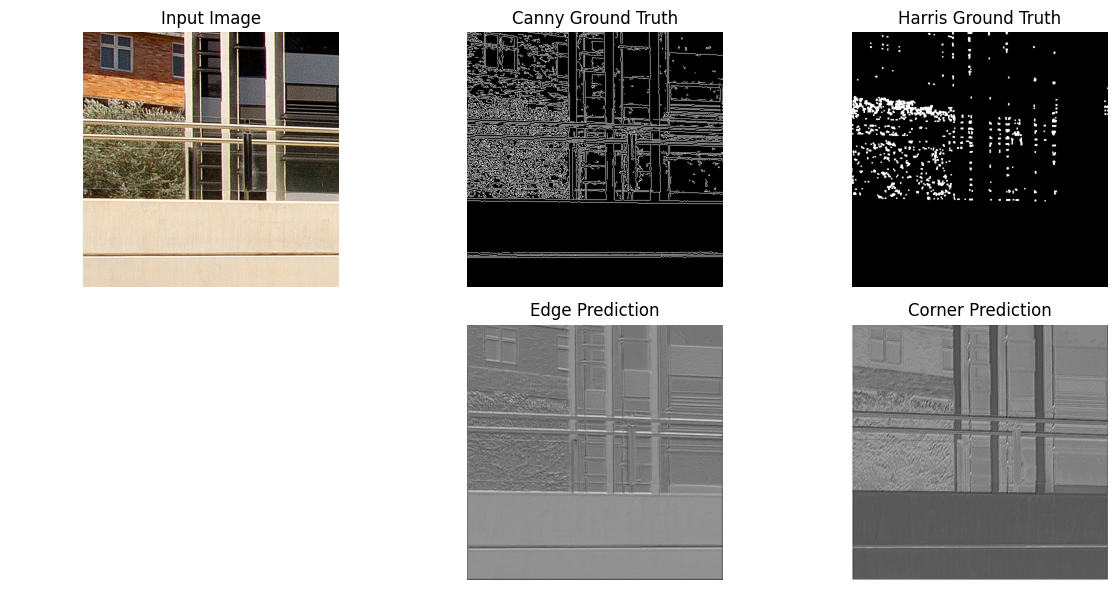

In [4]:
# Convert tensors to numpy for visualization
img = images[0].permute(1, 2, 0).numpy()        # [H, W, C]
edge_pred = outputs[0, 0].numpy()
corner_pred = outputs[0, 1].numpy()
edge_true = labels[0, 0].numpy()
corner_true = labels[0, 1].numpy()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(img)
axes[0, 0].set_title("Input Image")
axes[0, 1].imshow(edge_true, cmap='gray')
axes[0, 1].set_title("Canny Ground Truth")
axes[0, 2].imshow(corner_true, cmap='gray')
axes[0, 2].set_title("Harris Ground Truth")
axes[1, 1].imshow(edge_pred, cmap='gray')
axes[1, 1].set_title("Edge Prediction")
axes[1, 2].imshow(corner_pred, cmap='gray')
axes[1, 2].set_title("Corner Prediction")

for ax in axes.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()

## Resnet-18 Style Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple residual block
class BasicBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.downsample = None
        if input_channel != output_channel or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(output_channel)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsample:
            identity = self.downsample(identity)
            
        return self.relu(out + identity)

# Main model with skip connections
class ResNetLiteDualHeadSkip(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(input_channel, output_channel):
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace = True),
                nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace = True),
            )

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        # Encoder
        self.layer1 = BasicBlock(64, 128, stride = 2)   # 128 × 64 × 64
        self.layer2 = BasicBlock(128, 256, stride = 2)  # 256 × 32 × 32
        self.layer3 = BasicBlock(256, 512, stride = 2)  # 512 × 16 × 16

        # Decoder upsampling
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)  # → 32 × 32
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)  # → 64 × 64
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)   # → 128 × 128
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2)    # → 256 × 256
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2)    # → 512 × 512

        # Decoder conv blocks with skip connections
        self.dec1 = conv_block(256 + 256, 256)
        self.dec2 = conv_block(128 + 128, 128)
        self.dec3 = conv_block(64 + 64, 64)
        self.dec4 = conv_block(32, 32)
        self.dec5 = conv_block(16, 16)

        # Output heads
        self.out_edge = nn.Conv2d(16, 1, kernel_size=1)
        self.out_corner = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        s = self.stem(x)     # 64 × 128 × 128
        l1 = self.layer1(s)  # 128 × 64 × 64
        l2 = self.layer2(l1) # 256 × 32 × 32
        l3 = self.layer3(l2) # 512 × 16 × 16

        # Decoder with skip connections
        x = self.up1(l3)                      # 256 × 32 × 32
        x = self.dec1(torch.cat([x, l2], 1))

        x = self.up2(x)                       # 128 × 64 × 64
        x = self.dec2(torch.cat([x, l1], 1))

        x = self.up3(x)                       # 64 × 128 × 128
        x = self.dec3(torch.cat([x, s], 1))

        x = self.up4(x)                       # 32 × 256 × 256
        x = self.dec4(x)

        x = self.up5(x)                       # 16 × 512 × 512
        x = self.dec5(x)

        # Output heads
        edge = torch.sigmoid(self.out_edge(x))
        corner = torch.sigmoid(self.out_corner(x))

        return torch.cat([edge, corner], dim = 1)  # [B, 2, 512, 512]

## Simpler Model without skip connections

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.downsample = None
        if input_channel != output_channel or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(output_channel),
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(identity)

        return self.relu(out + identity)

# ResNet-like backbone + dual output heads
class ResNetLiteDualHead(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        # ResNet-like blocks
        self.layer1 = BasicBlock(64, 128, stride = 2)   # Downsample
        self.layer2 = BasicBlock(128, 256, stride = 2)
        self.layer3 = BasicBlock(256, 512, stride = 2)

        # Decoder (upsample)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2)
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2)

        # Output heads
        self.out_edge = nn.Conv2d(16, 1, kernel_size = 1)
        self.out_corner = nn.Conv2d(16, 1, kernel_size = 1)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)

        edge = torch.sigmoid(self.out_edge(x))
        corner = torch.sigmoid(self.out_corner(x))
        return torch.cat([edge, corner], dim = 1)

In [7]:
resnet_noskip_model = ResNetLiteDualHead().to('cpu')
resnet_noskip_model.eval()

with torch.no_grad():
    outputs = resnet_noskip_model(images)
    
print(outputs.shape)

torch.Size([4, 2, 512, 512])


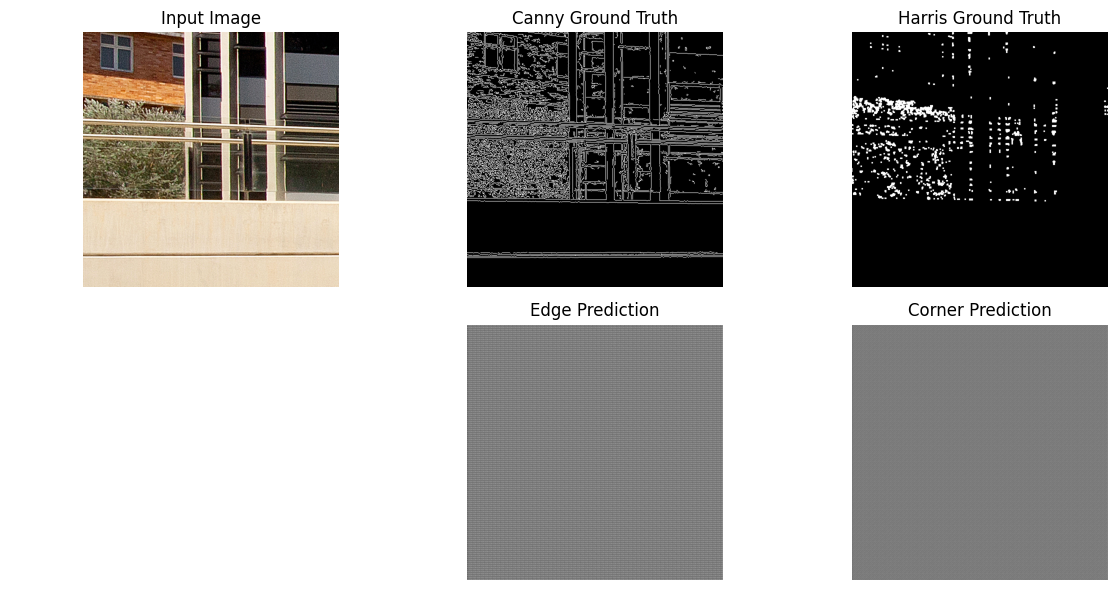

In [8]:
# Convert tensors to numpy for visualization
img = images[0].permute(1, 2, 0).numpy()        # [H, W, C]
edge_pred = outputs[0, 0].numpy()
corner_pred = outputs[0, 1].numpy()
edge_true = labels[0, 0].numpy()
corner_true = labels[0, 1].numpy()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(img)
axes[0, 0].set_title("Input Image")
axes[0, 1].imshow(edge_true, cmap='gray')
axes[0, 1].set_title("Canny Ground Truth")
axes[0, 2].imshow(corner_true, cmap='gray')
axes[0, 2].set_title("Harris Ground Truth")
axes[1, 1].imshow(edge_pred, cmap='gray')
axes[1, 1].set_title("Edge Prediction")
axes[1, 2].imshow(corner_pred, cmap='gray')
axes[1, 2].set_title("Corner Prediction")

for ax in axes.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [9]:
resnet_skip_model = ResNetLiteDualHeadSkip().to('cpu')
resnet_skip_model.eval()

with torch.no_grad():
    outputs = resnet_skip_model(images)
    
print(outputs.shape)

torch.Size([4, 2, 512, 512])


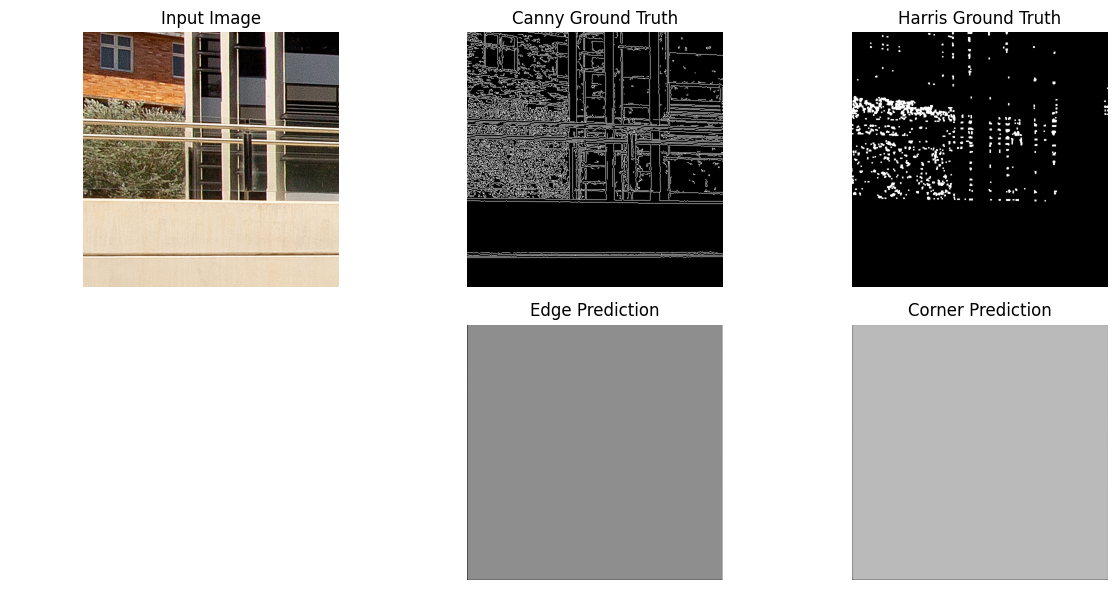

In [10]:
# Convert tensors to numpy for visualization
img = images[0].permute(1, 2, 0).numpy()        # [H, W, C]
edge_pred = outputs[0, 0].numpy()
corner_pred = outputs[0, 1].numpy()
edge_true = labels[0, 0].numpy()
corner_true = labels[0, 1].numpy()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(img)
axes[0, 0].set_title("Input Image")
axes[0, 1].imshow(edge_true, cmap='gray')
axes[0, 1].set_title("Canny Ground Truth")
axes[0, 2].imshow(corner_true, cmap='gray')
axes[0, 2].set_title("Harris Ground Truth")
axes[1, 1].imshow(edge_pred, cmap='gray')
axes[1, 1].set_title("Edge Prediction")
axes[1, 2].imshow(corner_pred, cmap='gray')
axes[1, 2].set_title("Corner Prediction")

for ax in axes.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()